***1) Import Dependencies***

In [2]:
# Initial Imports
import pandas as pd
import numpy as np
import math
import shrimpy
from pathlib import Path
from dotenv import load_dotenv
import time
from joblib import dump,load # Save Models
from numpy import random
import os
from datetime import date, datetime, timedelta
import matplotlib.pyplot as plt
from datetime import timedelta
pd.set_option('display.float_format', lambda x: '%.5f' % x)
pd.set_option('display.float_format', lambda x: '%.5f' % x)

***2) Set Strategy Parameters***

In [71]:
# Set Strategy Parameters
initial_capital = 1
# Universe
universe_assets = ['XBT']
quote_currencies = ['USD']
wt_threshold = .6 # Initial Allocation to Bitcoin when ema cross buy signal
interval = '1h'
start = '2017-05-01'
end = '2017-12-18'
# Technical
fast_period = 9 # Fast Exponential Moving Average Lookback Period
slow_period = 21 # Slow Ripple Exponential Moving Average Lookback Period
csv_path_training = Path("/Users/gdepa/github/public/Understanding-Bitcoin-ML")/'kraken_prices_1h_df_e3_p1.csv'
csv_path_sample = Path("/Users/gdepa/github/public/Understanding-Bitcoin-ML")/'kraken_prices_1h_df_e4_p1.csv'

***3) Fetch Data***

In [4]:
training_set = pd.read_csv(csv_path_training)
sample_set = pd.read_csv(csv_path_sample)

In [5]:
training_set

,Unnamed: 0,open,high,low,close,volume,quoteVolume,time
0,0,1786.84100,1800.01700,1763.40300,1789.00000,409.77144,732402.80840,2017-05-17T00:00:00.000Z
1,1,1789.95900,1800.00000,1775.00000,1787.07100,397.70246,709997.74357,2017-05-17T01:00:00.000Z
2,2,1787.07000,1805.00000,1771.79800,1794.21100,439.54562,785160.58993,2017-05-17T02:00:00.000Z
3,3,1798.35300,1817.99600,1794.60300,1807.07100,400.63502,724140.54106,2017-05-17T03:00:00.000Z
4,4,1807.13000,1834.99600,1807.13000,1820.63000,239.38647,436126.64903,2017-05-17T04:00:00.000Z
...,...,...,...,...,...,...,...,...
5079,546,18800.00000,19250.00000,18800.00000,18931.30000,160.74564,3071093.53159,2017-12-17T20:00:00.000Z
5080,547,18931.40000,18933.20000,18700.00000,18851.10000,98.28926,1845024.23533,2017-12-17T21:00:00.000Z
5081,548,18853.00000,19350.00000,18816.90000,19232.00000,127.42284,2437711.30142,2017-12-17T22:00:00.000Z
5082,549,19232.00000,19237.30000,18802.00000,18920.60000,215.12430,4076536.07637,2017-12-17T23:00:00.000Z


In [6]:
sample_set

,Unnamed: 0,open,high,low,close,volume,quoteVolume,time
0,0,1786.84100,1800.01700,1763.40300,1789.00000,409.77144,732402.80840,2017-05-17T00:00:00.000Z
1,1,1789.95900,1800.00000,1775.00000,1787.07100,397.70246,709997.74357,2017-05-17T01:00:00.000Z
2,2,1787.07000,1805.00000,1771.79800,1794.21100,439.54562,785160.58993,2017-05-17T02:00:00.000Z
3,3,1798.35300,1817.99600,1794.60300,1807.07100,400.63502,724140.54106,2017-05-17T03:00:00.000Z
4,4,1807.13000,1834.99600,1807.13000,1820.63000,239.38647,436126.64903,2017-05-17T04:00:00.000Z
...,...,...,...,...,...,...,...,...
5848,764,32823.50000,32948.40000,32625.70000,32626.30000,73.33492,2403971.58834,2021-06-27T20:00:00.000Z
5849,765,32630.80000,32870.10000,32474.50000,32862.40000,79.14899,2581401.41483,2021-06-27T21:00:00.000Z
5850,766,32862.40000,34585.60000,32824.10000,34414.60000,766.75356,26046902.56977,2021-06-27T22:00:00.000Z
5851,767,34424.70000,34700.00000,34199.30000,34675.30000,198.27389,6829598.67411,2021-06-27T23:00:00.000Z


***4) Define Backtest Function***

In [69]:
def btc_usd_kraken_backtest(initial_capital, training_set, wt_threshold,interval, fast_period,slow_period):
    #df_balances_kraken, df_balances_kucoin, df_balances_coinbasepro = get_balances(shrimpy_user_id, kraken_id, kucoin_id, coinbasepro_id)
    df_universe_prices = training_set
    df_universe_prices['price'] = training_set['close'].astype(float)
    df_universe_prices['returns'] = df_universe_prices['price'].pct_change()
    df_universe_prices['ema_fast'] = df_universe_prices['price'].ewm(halflife=fast_period).mean()
    df_universe_prices['ema_slow'] = df_universe_prices['price'].ewm(halflife=slow_period).mean()  
    df_universe_prices['crossover_long'] = np.where(df_universe_prices['ema_fast'] > df_universe_prices['ema_slow'],1.0,0.0)
    df_universe_prices['crossover_short'] = np.where(df_universe_prices['ema_fast'] < df_universe_prices['ema_slow'],-1.0,0.0)
    df_universe_prices['crossover_signal'] = df_universe_prices['crossover_long'] + df_universe_prices['crossover_short']
    signal_df = df_universe_prices[['price','crossover_signal', 'returns']]
    signal_df['btc_wt'] = np.where(signal_df['crossover_signal'] == 1.0, wt_threshold,0)
    signal_df['usd_wt'] = 1-signal_df['btc_wt']
    # Action Happens one candle after signal is generated
    signal_df['btc_wt'] = signal_df['btc_wt'].shift(1)
    signal_df['usd_wt'] = signal_df['usd_wt'].shift(1)
    signal_df['price_prev'] = signal_df['price'].shift(1)

    usd_balance = []
    btc_balance = []
    btc_total = []
    usd_total = []
    cost_basis = []
    for index, row in signal_df.iterrows():
        if len(usd_balance) ==0:
            total_usd = initial_capital
            balance_usd = total_usd
            usd_total.append(total_usd)
            usd_balance.append(balance_usd)
        else:
            btc_all = row['btc_wt']*usd_balance[-1]
            btc_val = (btc_all / row['price_prev'])*row['price']
            usd_val = row['usd_wt']*usd_balance[-1]
            balance_usd = btc_val + usd_val
            usd_balance.append(balance_usd)


    signal_df['usd_balance'] = usd_balance
    signal_df['prt_returns'] = signal_df['usd_balance'].pct_change()
    signal_df['cum_prt_returns_usd'] = (1+signal_df['prt_returns']).cumprod()
    signal_df['cum_returns_btcusd'] = (1+signal_df['returns']).cumprod()
    
    cum_returns = (signal_df['cum_prt_returns_usd'].iloc[-1])
    cum_returns_tot = cum_returns * initial_capital
   # BTC_accumulation_rate =  (signal_df['cum_returns_btc'][-1]-1)
    #BTC_accumulation = BTC_accumulation_rate * signal_df['btc_balance'][0]
   # btcusd_return_rate = (signal_df['cum_returns_btcusd'][-1]) -1
   # btcusd_returns = btcusd_return_rate * initial_capital
    df_universe_prices[['price','ema_fast','ema_slow']].plot(figsize=[12,7]) 
    signal_df[['cum_prt_returns_usd']].plot(figsize=[12,7])
    print(f"--------------- BackTest Info -------------------------")
    print(f"Initial Capital = {initial_capital} USD")
    print(f"Interval = {interval}")
    print(f"wt_threshold = {wt_threshold}")
    print(f"----------- Performance Stats --------------------------")
    print(f"Capital at End of Period = {signal_df['usd_balance'].iloc[-1]} USD")
    print(f"USD Accumulation = {cum_returns_tot} USD, {cum_returns} ")
    #print(f"BTC Accumulation = {BTC_accumulation} BTC, {BTC_accumulation_rate*100} %")
    #print(f"Benchmarks")
    #print(f"    btcusd returns = {btcusd_returns} USD, {btcusd_return_rate} BTC")
    # Plot Cum_returns
    # Plot Returns
    #signal_df[['usd_change', 'btc_change']].plot(figsize=[7,7])

<ipython-input-69-9f044996098b>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  signal_df['btc_wt'] = np.where(signal_df['crossover_signal'] == 1.0, wt_threshold,0)
<ipython-input-69-9f044996098b>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  signal_df['usd_wt'] = 1-signal_df['btc_wt']
<ipython-input-69-9f044996098b>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentati

--------------- BackTest Info -------------------------
Initial Capital = 10000 USD
Interval = 1h
wt_threshold = 0.6
----------- Performance Stats --------------------------
Capital at End of Period = 36706.501954901985 USD
USD Accumulation = 36706.50195490176 USD, 3.670650195490176 


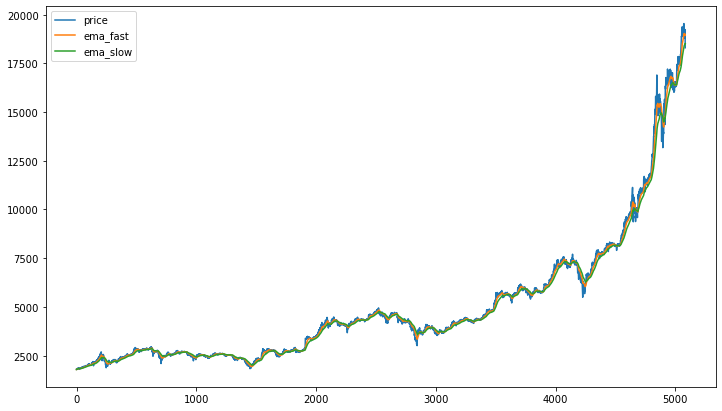

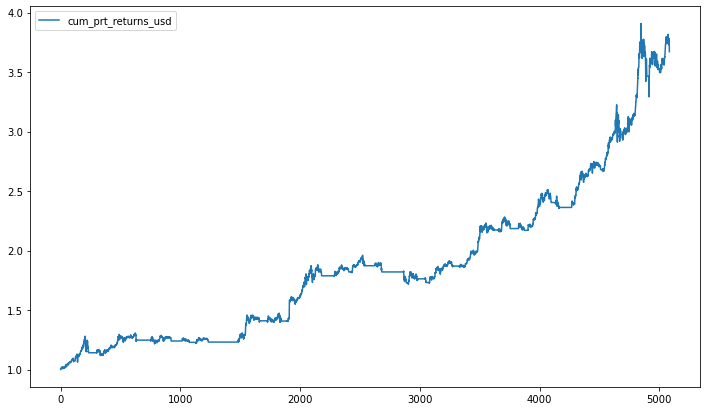

In [70]:
btc_usd_kraken_backtest(initial_capital, training_set, wt_threshold,interval, fast_period,slow_period)

**Improvements**  

1. Use LSTM model to optimize wt threshold and EMA Lookback windows for excess returns
2. Test LSTM model on out of sample dataset
3. Deploy trading bot leveraging shrimpy api
4. Use Leverage